# 라이브러리

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.init as init
from torch.optim import lr_scheduler

# 데이터 가져오기

In [2]:
datapath = "./data/winequalityN.csv"

data_sets = pd.read_csv(datapath, delimiter = ',')

data_sets.dropna(inplace = True, axis = 0)

x_data = data_sets.drop(columns = ["type", "quality"],axis = 1)

y_data = np.where(data_sets['quality'] > 5, 1.0, 0.0)
y_data = [[i] for i in y_data]

print(data_sets.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6463.000000       6463.000000  6463.000000     6463.000000   
mean        7.217755          0.339589     0.318758        5.443958   
std         1.297913          0.164639     0.145252        4.756852   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6463.000000          6463.000000           6463.000000  6463.000000   
mean      0.056056            30.516865            115.694492     0.994698   
std       0.035076            17.758815             56.526736     0.003001   
min       0.009000             1.000000         

# 데이터 정규화

In [3]:
def norm(df,key):
    c = df[key]
    df_min = c.min()
    df_max = c.max()
#     print("key=> ",key,"min",df_min,"max",df_max)
    df[key] = (c-df_min)/(df_max-df_min)

x_columns = x_data.columns.tolist()
# norm_list = ['fixed acidity','residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'pH','alcohol']

for i in x_columns:
    norm(x_data, i)

# train, test 분할

In [4]:
x_data = x_data.values.tolist()

In [5]:
train_size = int(len(x_data) * 0.8)

x_train = x_data[:train_size]
y_train = y_data[:train_size]

x_test = x_data[train_size:]
y_test = y_data[train_size:]

feature_size = len(x_train[0])
learning_rate = 0.0001

In [6]:
torch.manual_seed(1)

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(y_train[3])

torch.Size([5170, 11])
torch.Size([5170, 1])
tensor([1.])


# 모델 선언

In [8]:
class binary_logistic(nn.Module):
    def __init__(self):
        super(binary_logistic, self).__init__()
        self.drop_rate = 0.5
        self.layer = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ELU(),
            nn.Dropout2d(self.drop_rate),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Dropout2d(self.drop_rate),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Dropout2d(self.drop_rate),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Dropout2d(self.drop_rate),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Dropout2d(self.drop_rate),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Dropout2d(self.drop_rate),
            nn.BatchNorm1d(16),
            
            nn.Linear(16, 8),
            nn.ELU(),
            nn.Dropout2d(self.drop_rate),
            nn.BatchNorm1d(8),
            
            nn.Linear(8, 4),
            nn.ELU(),
            nn.Dropout2d(self.drop_rate),
            nn.BatchNorm1d(4),
            
            nn.Linear(4, 2),
            nn.ELU(),
            nn.Dropout2d(0.3),
            nn.BatchNorm1d(2),
            
            nn.Linear(2, 1),
            nn.Sigmoid(),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        
    def forward(self, x):
        out = self.layer(x)

        return out
    

model = binary_logistic().cuda()

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:57: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


# optimizer

In [9]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.00001)

# train

In [10]:
graph_x = []
graph_y = []

nb_epochs = 8000

model.train()

for epoch in range(nb_epochs + 1):
    x = Variable(x_train).cuda()
    y_ = Variable(y_train).cuda()
    
    prediction = model.forward(x)

    cost = F.binary_cross_entropy(prediction, y_)


    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    graph_x.append(epoch)
    graph_y.append(cost)

    if epoch % 1000 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/8000 Cost: 0.805435
Epoch 1000/8000 Cost: 0.654229
Epoch 2000/8000 Cost: 0.615056
Epoch 3000/8000 Cost: 0.598624
Epoch 4000/8000 Cost: 0.580524
Epoch 5000/8000 Cost: 0.570233
Epoch 6000/8000 Cost: 0.551488
Epoch 7000/8000 Cost: 0.540955
Epoch 8000/8000 Cost: 0.536991


# 정확도 계산

In [11]:
def ComputeAcc(imodel):
    correct = 0
    total = len(y_test)

    x = Variable(x_test).cuda()
    _y = Variable(y_test).cuda()
    
    output = imodel.forward(x)
    prediction = output >= torch.FloatTensor([0.5]).cuda()
    
    correct += (prediction == _y).sum()
    acc = 100*correct/total

    return acc

In [12]:
model.eval()
acc = ComputeAcc(model)
print("Accuracy of Test Data : {}".format(acc))

Accuracy of Test Data : 72


# cost 그래프 그리기

In [13]:
def show_graph(cost_x, cost_y):
    plt.plot(cost_x, cost_y,'b-')
    plt.xlabel("Epoch")
    plt.ylabel("cost")
    plt.title("Cost Graph")
    plt.show()

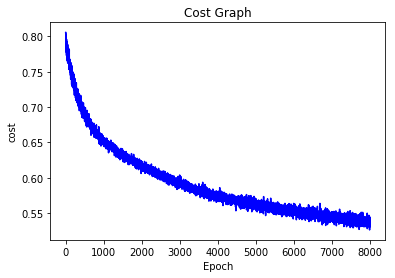

In [14]:
show_graph(graph_x, graph_y)

# 사용자 입력

In [15]:
x = [[7,0.27,0.36,20.7,0.045,45,170,1.0,3,0.45,8.8], # 6 - 1
     [6.2,0.66,0.48,1.2,0.029,29,75,0.9892,3.33,0.39,12.8], # 8 - 1
     [5.8,0.27,0.2,14.95,0.044,22,179,0.9962,3.37,0.37,10.2], # 5 - 0
     [7.6,0.48,0.37,0.8,0.037,4,100,0.9902,3.03,0.39,11.4], # 4 - 0
     [9.1,0.27,0.45,10.6,0.035,28,124,0.997,3.2,0.46,10.4], # 9 - 1
     [10.3,0.17,0.47,1.4,0.037,5,33,0.9939,2.89,0.28,9.6], # 3 - 0
     [8.3,0.27,0.45,1.3,0.048,8,72,0.9944,3.08,0.61,10.3], # 4 - 0
     [7.1,0.25,0.39,2.1,0.036,30,124,0.9908,3.28,0.43,12.2], # 8 - 1
     [5.6,0.29,0.05,0.8,0.038,11,30,0.9924,3.36,0.35,9.2], # 5 - 0
     [7.7,0.17,0.52,5.9,0.017,21,84,0.9929,3.14,0.4,11.9] # 7 - 1
    ]
y = [1, 1, 0, 0, 1, 0, 0, 1, 0, 1]

x_input = pd.DataFrame(x, columns = x_columns)

for i in x_columns:
    norm(x_input, i)
    
x_input = x_input.values.tolist()

# 사용자 입력 결과

In [16]:
x = torch.FloatTensor(x_input)

x_ = Variable(x).cuda()

model.eval()
output = model.forward(x_)
prediction = output >= torch.FloatTensor([0.5]).cuda()

prediction = np.array(prediction.to(device = torch.device('cpu')), dtype = np.int32)
prediction = prediction.reshape((-1,))

for i in range(len(prediction)):
    print("입력하신 binary_quality는 : {} 이고, 실제값은 : {} 입니다. 정답 여부는 : {} 입니다".
          format(prediction[i], y[i],prediction[i]==y[i]))

입력하신 binary_quality는 : 0 이고, 실제값은 : 1 입니다. 정답 여부는 : False 입니다
입력하신 binary_quality는 : 1 이고, 실제값은 : 1 입니다. 정답 여부는 : True 입니다
입력하신 binary_quality는 : 0 이고, 실제값은 : 0 입니다. 정답 여부는 : True 입니다
입력하신 binary_quality는 : 0 이고, 실제값은 : 0 입니다. 정답 여부는 : True 입니다
입력하신 binary_quality는 : 1 이고, 실제값은 : 1 입니다. 정답 여부는 : True 입니다
입력하신 binary_quality는 : 1 이고, 실제값은 : 0 입니다. 정답 여부는 : False 입니다
입력하신 binary_quality는 : 0 이고, 실제값은 : 0 입니다. 정답 여부는 : True 입니다
입력하신 binary_quality는 : 1 이고, 실제값은 : 1 입니다. 정답 여부는 : True 입니다
입력하신 binary_quality는 : 0 이고, 실제값은 : 0 입니다. 정답 여부는 : True 입니다
입력하신 binary_quality는 : 1 이고, 실제값은 : 1 입니다. 정답 여부는 : True 입니다
